# Random Forest

## Feature Generation

In [5]:
!pip install numpy


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np

# Исходные данные (если ещё не загружены)
df = pd.read_csv(
    'household_power_consumption.csv',
    sep=';',
    parse_dates=[[0, 1]],
    na_values='?',
    infer_datetime_format=True,
    low_memory=False
)

# Предобработка
df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df.set_index('Datetime', inplace=True)
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['Global_active_power']].resample('D').mean().interpolate()

# Скопируем для фичей
data = df.copy()
data = data.rename(columns={'Global_active_power': 'target'})

# Лаги (можно расширить)
for lag in [1, 2, 3, 7, 14]:
    data[f'lag_{lag}'] = data['target'].shift(lag)

# Календарные признаки
data['weekday'] = data.index.weekday
data['month'] = data.index.month
data['day'] = data.index.day
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(int)

# Удалим строки с NaN (в начале из-за лагов)
data.dropna(inplace=True)

# Выводим первые строки
print(data.head(10))


C:\Users\OsenD\AppData\Local\Temp\ipykernel_6308\3084578959.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\OsenD\AppData\Local\Temp\ipykernel_6308\3084578959.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


              target     lag_1     lag_2     lag_3     lag_7    lag_14  \
Datetime                                                                 
2006-12-30  1.939709  2.204439  1.439332  1.061639  3.314851  3.053475   
2006-12-31  2.426525  1.939709  2.204439  1.439332  1.770842  2.354486   
2007-01-01  1.909031  2.426525  1.939709  2.204439  1.904944  1.530435   
2007-01-02  0.881414  1.909031  2.426525  1.939709  2.732021  1.157079   
2007-01-03  0.704204  0.881414  1.909031  2.426525  1.061639  1.545658   
2007-01-04  2.263481  0.704204  0.881414  1.909031  1.439332  1.193758   
2007-01-05  1.884281  2.263481  0.704204  0.881414  2.204439  1.625929   
2007-01-06  1.047485  1.884281  2.263481  0.704204  1.939709  3.314851   
2007-01-07  1.699736  1.047485  1.884281  2.263481  2.426525  1.770842   
2007-01-08  1.556500  1.699736  1.047485  1.884281  1.909031  1.904944   

            weekday  month  day  is_weekend  
Datetime                                     
2006-12-30        5

C:\Users\OsenD\AppData\Local\Temp\ipykernel_6308\3084578959.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


## 2.Train modell

[Random Forest] MAE: 0.200, RMSE: 0.261, MAPE: 21.59%


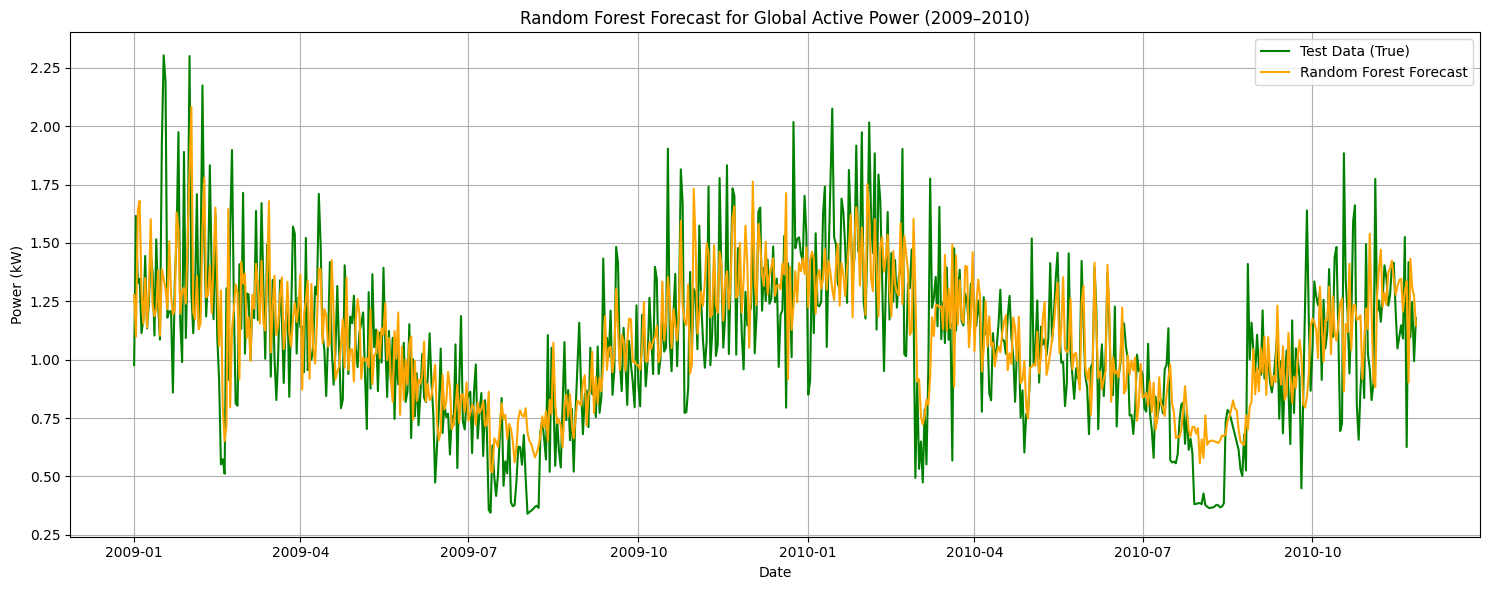

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# 1. Разделим на train/test (по годам)
train = data['2006-01-01':'2008-12-31']
test = data['2009-01-01':'2010-11-26']

# 2. Определим признаки и целевую переменную
features = [col for col in data.columns if col != 'target']
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

# 3. Обучение модели
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Прогноз
y_pred = model.predict(X_test)

# 5. Метрики
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

mae_rf, rmse_rf, mape_rf = compute_metrics(y_test.values, y_pred)
print(f"[Random Forest] MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}, MAPE: {mape_rf:.2f}%")

# 6. График сравнения
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Test Data (True)', color='green')
plt.plot(y_test.index, y_pred, label='Random Forest Forecast', color='orange')
plt.title('Random Forest Forecast for Global Active Power (2009–2010)')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  ! rmse werte in ARIMA_AIR prüfen
